# Interest Rates

In [51]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdates
import statsmodels.formula.api as sm
import os

home = os.path.expanduser('~')
import sys; sys.path.append(home + '/github/forecasting-mexico-national-accounts/')
import filters

In [52]:
df = pd.read_csv('../data/raw/mexico_interest_rates_quarterly.csv')
df = df.drop(columns = ['Unnamed: 1', 'Unnamed: 2', 'Scale'])
df = df.T
df

,0,1,2,3,4,5,6
Indicator,Central Bank Policy Rate,Money Market Rate,Treasury Bill Rate,Savings Rate,Deposit Rate,Lending Rate,Government Bonds
1990Q1,...,50.68,44.38,...,35.03,...,...
1990Q2,...,43.27,37.98,...,32.17,...,...
1990Q3,...,34.94,30.17,...,28.41,...,...
1990Q4,...,32.13,26.50,...,26.00,...,...
...,...,...,...,...,...,...,...
2021Q2,4.25,4.3,4.05,2.8,0.46,4.5,6.61
2021Q3,4.5,4.64,4.44,3.27,0.65,4.81,6.94
2021Q4,5.5,5.18,5.06,4.05,0.97,5.46,7.57
2022Q1,6.5,6.02,5.9,4.66,1.5,6.34,8.14


In [53]:
cpi = pd.read_csv('../data/raw/cpi.csv')
cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cpi     265 non-null    float64
 1   Y       265 non-null    int64  
 2   Q       265 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 6.3 KB


In [54]:
cpi.head(10)

,cpi,Y,Q
0,0.009960,1957,1
1,0.010710,1957,2
2,0.011276,1957,3
3,0.011642,1957,4
4,0.012075,1958,1
5,0.012087,1958,2
6,0.012225,1958,3
7,0.012489,1958,4
8,0.012465,1959,1
9,0.012531,1959,2


In [55]:
df.columns = df.iloc[0, :]
df = df.iloc[1:, :]
df = df.reset_index()
df = df.rename(columns={'index':'YQ'})

df[df == '...'] = np.nan
df.iloc[:, 2:] = df.iloc[:, 2:].astype('float64')
df['YQ'] = df['YQ'].astype('str')

df['Y'] = df['YQ'].apply(lambda x : x[:4]).astype('int64')
df['Q'] = df['YQ'].apply(lambda x : x[-1:]).astype('int64')
df['time'] = pd.to_datetime(df['Y'].astype('str') + '-Q' + df['Q'].astype('str'))

/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_32802/2325745960.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df['Y'].astype('str') + '-Q' + df['Q'].astype('str'))


In [56]:
df

Indicator,YQ,Central Bank Policy Rate,Money Market Rate,Treasury Bill Rate,Savings Rate,Deposit Rate,Lending Rate,Government Bonds,Y,Q,time
0,1990Q1,NaN,50.68,44.38,NaN,35.03,NaN,NaN,1990,1,1990-01-01
1,1990Q2,NaN,43.27,37.98,NaN,32.17,NaN,NaN,1990,2,1990-04-01
2,1990Q3,NaN,34.94,30.17,NaN,28.41,NaN,NaN,1990,3,1990-07-01
3,1990Q4,NaN,32.13,26.5,NaN,26.0,NaN,NaN,1990,4,1990-10-01
4,1991Q1,NaN,28.67,22.94,NaN,21.24,NaN,NaN,1991,1,1991-01-01
...,...,...,...,...,...,...,...,...,...,...,...
124,2021Q2,4.25,4.3,4.05,2.8,0.46,4.5,6.61,2021,2,2021-04-01
125,2021Q3,4.5,4.64,4.44,3.27,0.65,4.81,6.94,2021,3,2021-07-01
126,2021Q4,5.5,5.18,5.06,4.05,0.97,5.46,7.57,2021,4,2021-10-01
127,2022Q1,6.5,6.02,5.9,4.66,1.5,6.34,8.14,2022,1,2022-01-01


In [57]:
tofloat = [
    'Central Bank Policy Rate',
    'Money Market Rate', 
    'Treasury Bill Rate', 
    'Savings Rate', 
    'Deposit Rate', 
    'Lending Rate', 
    'Government Bonds'
]
df[tofloat] = df[tofloat].astype(float)

In [58]:
cpi['pi_tp1_gross'] = cpi.cpi / cpi.cpi.shift(4)
cpi['inv_pi_tp1_gross'] = 1 / cpi['pi_tp1_gross']
cpi['pi'] = cpi['pi_tp1_gross'] - 1

pimodel = sm.ols(
   formula='inv_pi_tp1_gross ~ 1 + inv_pi_tp1_gross.shift(1) + inv_pi_tp1_gross.shift(2)' ,
   data=cpi
)
cpi_fit = pimodel.fit()
cpi_fit.summary()

E_inv_pi_tp1_gross = cpi_fit.fittedvalues
E_inv_pi_tp1_gross.name = 'E_inv_pi_tp1_gross'
#cpi = pd.concat([cpi, E_inv_pi_tp1_gross], axis=1)
cpi = cpi.merge(E_inv_pi_tp1_gross, left_index=True, right_index=True)
cpi['E4_pi'] = (cpi['pi'].shift(1) + cpi['pi'].shift(2) + cpi['pi'].shift(3) + cpi['pi'].shift(4))/4

cpi['pi_post'] = (cpi.cpi.shift(-4) / cpi.cpi) - 1
cpi['pi_pre'] = (cpi.cpi.shift(4) / cpi.cpi) - 1
cpi['Pi'] = cpi['cpi'] / cpi['cpi'].shift(4)

cpi.head()

,cpi,Y,Q,pi_tp1_gross,inv_pi_tp1_gross,pi,E_inv_pi_tp1_gross,E4_pi,pi_post,pi_pre,Pi
6,0.012225,1958,3,1.084177,0.922359,0.084177,0.925672,NaN,0.025553,NaN,NaN
7,0.012489,1958,4,1.072755,0.932179,0.072755,0.944630,NaN,0.009620,NaN,NaN
8,0.012465,1959,1,1.032338,0.968675,0.032338,0.936898,NaN,0.014217,NaN,NaN
9,0.012531,1959,2,1.036779,0.964525,0.036779,0.989761,NaN,0.032407,NaN,NaN
10,0.012537,1959,3,1.025553,0.975084,0.025553,0.959196,0.056512,0.074653,-0.024916,1.025553


In [59]:
df = df.merge(cpi[['Y', 'Q', 'cpi', 'E_inv_pi_tp1_gross', 'E4_pi', 'pi_post', 'pi_pre', 'Pi']],
                  on=['Y', 'Q'],
                  how='inner')

In [60]:
todivide = [['Lending Rate']] 

In [61]:
rename = {
    'Lending Rate':'lending',
    'Deposit Rate':'deposit',
    'Treasury Bill Rate':'treasury',
    'Money Market Rate':'money_market'
}

df = df.rename(columns=rename)

In [62]:
var = ['lending', 'deposit', 'treasury', 'money_market']
df[var] = df[var] / 100

In [63]:
df['lending_reg'] = (1+ df['lending'])*df['E_inv_pi_tp1_gross'] - 1
df['deposit_reg'] = (1+( df['deposit']))*df['E_inv_pi_tp1_gross'] - 1
df['treasury_reg'] = (1+ df['treasury'])*df['E_inv_pi_tp1_gross'] - 1
df['money_market_reg'] = (1+( df['money_market']))*df['E_inv_pi_tp1_gross'] - 1

df['lending_roll'] =  df['lending'] - df['E4_pi']
df['deposit_roll'] =  df['deposit'] - df['E4_pi']
df['treasury_roll'] =  df['treasury'] - df['E4_pi']
df['money_market_roll'] =  df['money_market'] - df['E4_pi']

df['lending_post'] =  df['lending'] - df['pi_post']
df['deposit_post'] =  df['deposit'] - df['pi_post']
df['treasury_post'] =  df['treasury'] - df['pi_post']
df['money_market_post'] =  df['money_market'] - df['pi_post']

In [64]:
rates = [
         'lending_reg', 'deposit_reg', 'treasury_reg', 'money_market_reg',
         'lending_roll', 'deposit_roll', 'treasury_roll', 'money_market_roll',
         'lending_post', 'deposit_post', 'treasury_post', 'money_market_post'
         ]

# Equity Measure

In [65]:
ipc = pd.read_csv('../data/raw/ipc_index.csv')
ipc

,Date,Open,High,Low,Close,Adj Close,Volume
0,1991-12-01,1375.400024,1431.500000,1273.199951,1431.500000,1431.500000,0
1,1992-01-01,1444.900024,1623.500000,1444.900024,1623.500000,1623.500000,0
2,1992-02-01,1624.500000,1860.599976,1616.099976,1860.599976,1860.599976,0
3,1992-03-01,1873.900024,1907.300049,1734.800049,1875.699951,1875.699951,0
4,1992-04-01,1852.500000,1897.099976,1741.400024,1838.300049,1838.300049,0
...,...,...,...,...,...,...,...
372,2022-12-01,51649.601563,51811.171875,48383.199219,48463.859375,48463.859375,2867541400
373,2023-01-01,48506.039063,55309.968750,48478.941406,54564.269531,54564.269531,2793205500
374,2023-02-01,54555.910156,55173.578125,52141.140625,52758.058594,52758.058594,3428245600
375,2023-03-01,52720.398438,54604.070313,51814.679688,53904.000000,53904.000000,4321742400


In [66]:
ipc['time'] = pd.to_datetime(ipc['Date'])
ipc['Q'] = [int(x.quarter) for x in ipc['time']]
ipc['Y'] = [int(x.year) for x in ipc['time']]
ipc = ipc[['time', 'Close', 'Q', 'Y']]

ipc_quarterly = (ipc.groupby(['Q', 'Y'], as_index=False)['Close']
                 .apply(np.mean)
                 .sort_values(['Y', 'Q']))
ipc_quarterly = ipc_quarterly.rename(columns={'Close':'EquityPrice'})
ipc_quarterly['EquityReturn'] = ipc_quarterly['EquityPrice'] / ipc_quarterly['EquityPrice'].shift(4)-1
ipc_quarterly = ipc_quarterly.reset_index(drop=True)
ipc_quarterly.head(10)


,Q,Y,EquityPrice,EquityReturn
0,4,1991,1431.500000,NaN
1,1,1992,1786.599976,NaN
2,2,1992,1776.633382,NaN
3,3,1992,1432.399984,NaN
4,4,1992,1690.900024,0.181209
5,1,1993,1657.199951,-0.072428
6,2,1993,1647.366699,-0.072759
7,3,1993,1836.733358,0.282277
8,4,1993,2277.400024,0.346857
9,1,1994,2593.033284,0.564708


In [67]:
df = df.merge(ipc_quarterly, on=['Y', 'Q'], how='outer')
df['EquityPriceReal'] = df['EquityPrice']  / df['cpi']
df['EquityReturn_roll'] = df['EquityReturn'] - df['E4_pi']
df['EquityReturn_post'] = df['EquityReturn'] - df['pi_post']
df['EquityReturn_reg'] = (1+ df['EquityReturn'] / 100)*df['E_inv_pi_tp1_gross'] - 1
df.head(15)

,YQ,Central Bank Policy Rate,money_market,treasury,Savings Rate,deposit,lending,Government Bonds,Y,Q,...,lending_post,deposit_post,treasury_post,money_market_post,EquityPrice,EquityReturn,EquityPriceReal,EquityReturn_roll,EquityReturn_post,EquityReturn_reg
0,1990Q1,NaN,0.5068,0.4438,NaN,0.3503,NaN,NaN,1990,1,...,NaN,0.084995,0.178495,0.241495,NaN,NaN,NaN,NaN,NaN,NaN
1,1990Q2,NaN,0.4327,0.3798,NaN,0.3217,NaN,NaN,1990,2,...,NaN,0.078300,0.136400,0.189300,NaN,NaN,NaN,NaN,NaN,NaN
2,1990Q3,NaN,0.3494,0.3017,NaN,0.2841,NaN,NaN,1990,3,...,NaN,0.074282,0.091882,0.139582,NaN,NaN,NaN,NaN,NaN,NaN
3,1990Q4,NaN,0.3213,0.2650,NaN,0.2600,NaN,NaN,1990,4,...,NaN,0.065320,0.070320,0.126620,NaN,NaN,NaN,NaN,NaN,NaN
4,1991Q1,NaN,0.2867,0.2294,NaN,0.2124,NaN,NaN,1991,1,...,NaN,0.038895,0.055895,0.113195,NaN,NaN,NaN,NaN,NaN,NaN
5,1991Q2,NaN,0.2619,0.1954,NaN,0.1780,NaN,NaN,1991,2,...,NaN,0.015463,0.032863,0.099363,NaN,NaN,NaN,NaN,NaN,NaN
6,1991Q3,NaN,0.2546,0.1758,NaN,0.1631,NaN,NaN,1991,3,...,NaN,0.008628,0.021328,0.100128,NaN,NaN,NaN,NaN,NaN,NaN
7,1991Q4,NaN,0.2130,0.1705,NaN,0.1651,NaN,NaN,1991,4,...,NaN,0.032936,0.038336,0.080836,1431.500000,NaN,93.957941,NaN,NaN,NaN
8,1992Q1,NaN,0.1704,0.1390,NaN,0.1399,NaN,NaN,1992,1,...,NaN,0.031032,0.030132,0.061532,1786.599976,NaN,111.237050,NaN,NaN,NaN
9,1992Q2,NaN,0.1755,0.1369,NaN,0.1319,NaN,NaN,1992,2,...,NaN,0.032044,0.037044,0.075644,1776.633382,NaN,107.760775,NaN,NaN,NaN


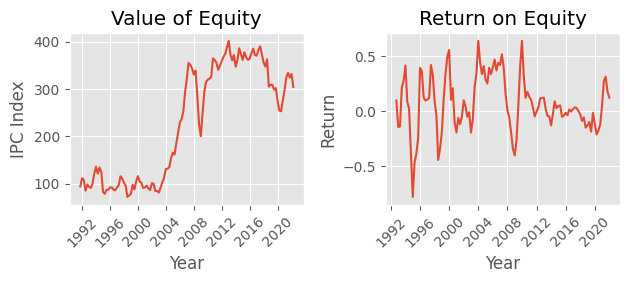

In [68]:
plt.subplot(221)
plt.plot(df.time, df['EquityPriceReal'])
plt.xlabel('Year')
plt.ylabel('IPC Index')
plt.title('Value of Equity')
plt.xticks(rotation=45)

plt.subplot(222)
plt.plot(df.time, 100 * df['EquityReturn_post'])
plt.xlabel('Year')
plt.ylabel('Return (%)')
plt.title('Return on Equity')
plt.xticks(rotation=45)

plt.tight_layout();

# Mexican Peso Crisis

## Real Interest Rates

<Figure size 640x480 with 0 Axes>

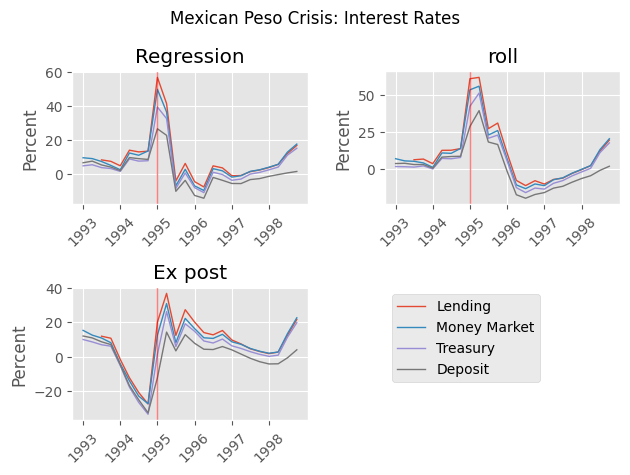

In [69]:
dates = [pd.to_datetime((str(x))) for x in np.arange(1993, 1997+1)]

focus = df.copy().query('Y <= 1998').query('Y >= 1993')
xmin = pd.to_datetime('1993Q1')
xmax = pd.to_datetime('1997Q4')
crisis = pd.to_datetime('1995Q1')

drange = pd.date_range('1993', '1998', freq='YS')

opt_crisis = {'color':'red', 'linestyle':'-', 'alpha':0.5, 'linewidth':1}
opt = {'linewidth':1}

plt.clf()
fig = plt.figure()
plt.suptitle('Mexican Peso Crisis: Interest Rates')

ax = plt.subplot(221)
lending, =ax.plot(focus.time, 100*focus['lending_reg'], label='Lending Rate', **opt)
mmarket, =ax.plot(focus.time, 100*focus['money_market_reg'], label='Money Market Rate', **opt)
treasury, =ax.plot(focus.time, 100*focus['treasury_reg'], label='Treasury Bill Rate', **opt)
deposit, =ax.plot(focus.time, 100*focus['deposit_reg'], label='Deposit Rate', **opt)
ax.axvline(crisis, **opt_crisis)
ax.set_xticks(drange)
ax.set_xticklabels(labels=ax.get_xticks(), rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_ylabel('Percent')
ax.set_title('Regression')

ax = plt.subplot(222)
ax.plot(focus.time, 100*focus['lending_roll'], label='Lending Rate', **opt)
ax.plot(focus.time, 100*focus['money_market_roll'], label='Money Market Rate', **opt)
ax.plot(focus.time, 100*focus['treasury_roll'], label='Treasury Bill Rate', **opt)
ax.plot(focus.time, 100*focus['deposit_roll'], label='Deposit Rate', **opt)
ax.axvline(crisis, **opt_crisis)
ax.set_xticks(drange)
ax.set_xticklabels(labels=ax.get_xticks(), rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_ylabel('Percent')
ax.set_title('Rolling')

ax = plt.subplot(223)
ax.plot(focus.time, 100*focus['lending_post'], label='Lending Rate', **opt)
ax.plot(focus.time, 100*focus['money_market_post'], label='Money Market Rate', **opt)
ax.plot(focus.time, 100*focus['treasury_post'], label='Treasury Bill Rate', **opt)
ax.plot(focus.time, 100*focus['deposit_post'], label='Deposit Rate', **opt)
ax.axvline(crisis, **opt_crisis)
ax.set_xticks(drange)
ax.set_xticklabels(labels=ax.get_xticks(), rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_ylabel('Percent')
ax.set_title('Ex post')

ax = plt.subplot(224)
ax.axis('off')
ax.legend((lending, mmarket, treasury, deposit), ('Lending', 'Money Market', 'Treasury', 'Deposit'), 
          loc='upper left')

plt.tight_layout()

plt.savefig('../fig/mpc_real_rates.png', dpi = 300)

## Nominal Interest Rates

<Figure size 640x480 with 0 Axes>

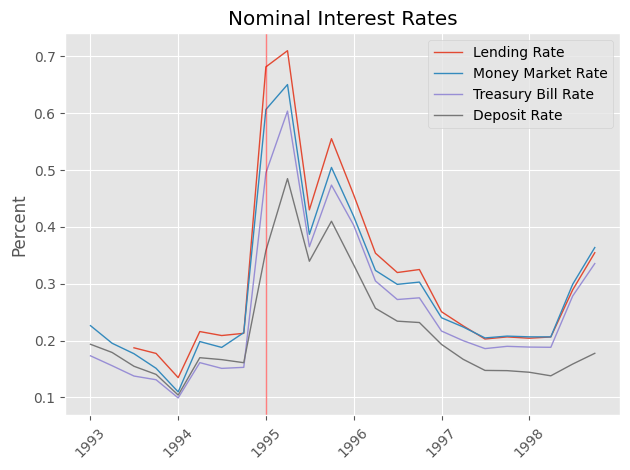

In [70]:
dates = [pd.to_datetime((str(x))) for x in np.arange(1993, 1997+1)]

focus = df.copy().query('Y <= 1998').query('Y >= 1993')
xmin = pd.to_datetime('1993Q1')
xmax = pd.to_datetime('1997Q4')
crisis = pd.to_datetime('1995Q1')

drange = pd.date_range('1993', '1998', freq='YS')

opt_crisis = {'color':'red', 'linestyle':'-', 'alpha':0.5, 'linewidth':1}
opt = {'linewidth':1}

plt.clf()
fig = plt.figure()

ax = plt.subplot(111)
ax.plot(focus.time, focus['lending'], label='Lending Rate', **opt)
ax.plot(focus.time, focus['money_market'], label='Money Market Rate', **opt)
ax.plot(focus.time, focus['treasury'], label='Treasury Bill Rate', **opt)
ax.plot(focus.time, focus['deposit'], label='Deposit Rate', **opt)
ax.axvline(crisis, **opt_crisis)
ax.set_xticks(drange)
ax.set_xticklabels(labels=ax.get_xticks(), rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_ylabel('Percent')
ax.set_title('Nominal Interest Rates')
ax.legend()

plt.tight_layout()

plt.savefig('../fig/mpc_nominal_rates.png', dpi=300)

# Great Recession

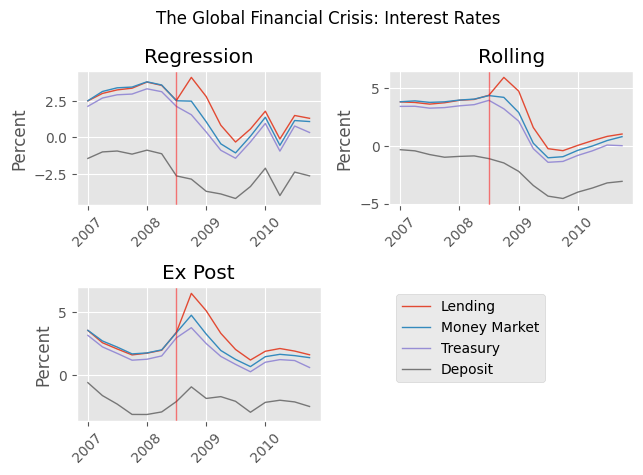

In [72]:
dates = [pd.to_datetime((str(x))) for x in np.arange(2006, 2010+1)]

focus = df.copy().query('Y <= 2010').query('Y >= 2007')
xmin = pd.to_datetime('2007Q1')
xmax = pd.to_datetime('2010Q4')
drange = pd.date_range('2007', '2010', freq='YS')

crisis = pd.to_datetime('2008Q3')
opt_crisis = {'color':'red', 'linestyle':'-', 'alpha':0.5, 'linewidth':1}

fig = plt.figure()
plt.suptitle('The Global Financial Crisis: Interest Rates')

ax = plt.subplot(221)
lending, =ax.plot(focus.time, 100*focus['lending_reg'], label='Lending Rate', **opt)
mmarket, =ax.plot(focus.time, 100*focus['money_market_reg'], label='Money Market Rate', **opt)
treasury, =ax.plot(focus.time, 100*focus['treasury_reg'], label='Treasury Bill Rate', **opt)
deposit, =ax.plot(focus.time, 100*focus['deposit_reg'], label='Deposit Rate', **opt)
ax.axvline(crisis, **opt_crisis)
ax.set_xticks(drange)
ax.set_xticklabels(labels=ax.get_xticks(), rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_ylabel('Percent')
ax.set_title('Regression')

ax = plt.subplot(222)
ax.plot(focus.time, 100*focus['lending_roll'], label='Lending Rate', **opt)
ax.plot(focus.time, 100*focus['money_market_roll'], label='Money Market Rate', **opt)
ax.plot(focus.time, 100*focus['treasury_roll'], label='Treasury Bill Rate', **opt)
ax.plot(focus.time, 100*focus['deposit_roll'], label='Deposit Rate', **opt)
ax.axvline(crisis, **opt_crisis)
ax.set_xticks(drange)
ax.set_xticklabels(labels=ax.get_xticks(), rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_ylabel('Percent')
ax.set_title('Rolling')

ax = plt.subplot(223)
ax.plot(focus.time, 100*focus['lending_post'], label='Lending Rate', **opt)
ax.plot(focus.time, 100*focus['money_market_post'], label='Money Market Rate', **opt)
ax.plot(focus.time, 100*focus['treasury_post'], label='Treasury Bill Rate', **opt)
ax.plot(focus.time, 100*focus['deposit_post'], label='Deposit Rate', **opt)
ax.axvline(crisis, **opt_crisis)
ax.set_xticks(drange)
ax.set_xticklabels(labels=ax.get_xticks(), rotation=45)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_ylabel('Percent')
ax.set_title('Ex Post')

ax = plt.subplot(224)
ax.axis('off')
ax.legend((lending, mmarket, treasury, deposit), ('Lending', 'Money Market', 'Treasury', 'Deposit'), 
          loc='upper left')

plt.tight_layout()

plt.savefig('../fig/gfc_interestrates.png', dpi=300)